# Studi Eksploratif: Analisis Kelayakan Klasifikasi Soal Otomatis Berdasarkan Kata Kerja Operasional Taksonomi Bloom

1. M Ilham Abdul Shaleh (F1D022061)
2. Nazila Imkani (F1D022084)
3. Fernandao Kwangtama Tekayadi (F1D022120)

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.ticker import PercentFormatter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Kode di atas merupakan menggunakan beberapa import dari library yang berbeda. Pandas dan numpy digunakan untuk manipulasi data dan operasi numerik, sedangkan matplotlib.pyplot dan seaborn digunakan untuk visualisasi data. Counter dari modul collections digunakan untuk menghitung frekuensi elemen dalam data. StemmerFactory dari pustaka Sastrawi digunakan untuk melakukan stemming (mengubah kata ke bentuk dasar) dalam teks berbahasa Indonesia. Terakhir, confusion_matrix, accuracy_score, dan classification_report dari sklearn.metrics digunakan untuk mengevaluasi performa model klasifikasi, termasuk akurasi dan metrik evaluasi lainnya.

In [35]:
def extract_tags (notation_string: str) -> list:
  if not isinstance(notation_string, str):
    return []
  
  tokens = notation_string.strip().split(' ')
  tags = [token.rsplit('/', 1)[-1] for token in tokens if '/' in token]
  return tags

Fungsi di atas bertujuan untuk mengekstrak tag dari sebuah string yang menggunakan format anotasi, di mana setiap token terdiri dari kata dan tag yang dipisahkan oleh karakter garis miring (/). Fungsi ini pertama-tama memeriksa apakah input bertipe string; jika tidak, ia mengembalikan list kosong. Jika valid, string dipangkas dari spasi di awal dan akhir, lalu dipisah berdasarkan spasi untuk mendapatkan token

In [36]:
def calculate_accuracy(reference_tags: list, comparison_tags: list) -> float:
  total_tags = len(reference_tags)
  if total_tags == 0 or len(reference_tags) != len(comparison_tags):
    return 0.0
  
  correct_tags = sum(1 for ref_tag, comp_tag in zip(reference_tags, comparison_tags) if ref_tag == comp_tag)
  return correct_tags/total_tags

Fungsi di atas berguna untuk menghitung akurasi dengan membandingkan dua daftar tag reference_tags (sebagai acuan) dan comparison_tags

In [37]:
try:
  df_before_preprocessing = pd.read_csv('./data/sebelum-preprocessing-dataset-pos-taging-notasi-gpt-stanza-manual.csv')
  df_after_preprocessing = pd.read_csv('./data/sesudah-preprocessing-dataset-pos-taging-notasi-gpt-stanza-manual.csv')
  print("Berhasil membaca file")

except FileNotFoundError:
    print("ERROR: File tidak ditemukan!")

Berhasil membaca file


Kode di atas mencoba membaca dua file CSV yaitu kode dataset post tagging sebelum dan sesudah post tagging dengan notasi gpt, stanza

In [38]:
df_before_preprocessing['manual_tags'] = df_before_preprocessing['manual'].apply(extract_tags)
df_before_preprocessing['stanza_tags'] = df_before_preprocessing['stanza'].apply(extract_tags)
df_before_preprocessing['gpt_tags'] = df_before_preprocessing['gpt'].apply(extract_tags)

df_before_preprocessing['akurasi_stanza_sebelum_preprocessing'] = df_before_preprocessing.apply(lambda row: calculate_accuracy(row['manual_tags'], row['stanza_tags']), axis = 1)
df_before_preprocessing['akurasi_gpt_sebelum_preprocessing'] = df_before_preprocessing.apply(lambda row: calculate_accuracy(row['manual_tags'], row['gpt_tags']), axis = 1)

df_after_preprocessing['manual_tags'] = df_after_preprocessing['manual'].apply(extract_tags)
df_after_preprocessing['stanza_tags'] = df_after_preprocessing['stanza'].apply(extract_tags)
df_after_preprocessing['gpt_tags'] = df_after_preprocessing['gpt'].apply(extract_tags)

df_after_preprocessing['akurasi_stanza_setelah_preprocessing'] = df_after_preprocessing.apply(lambda row: calculate_accuracy(row['manual_tags'], row['stanza_tags']), axis = 1)
df_after_preprocessing['akurasi_gpt_setelah_preprocessing'] = df_after_preprocessing.apply(lambda row: calculate_accuracy(row['manual_tags'], row['gpt_tags']), axis = 1)

results_before_preprocessing = df_before_preprocessing[['soal', 'akurasi_gpt_sebelum_preprocessing', 'akurasi_stanza_sebelum_preprocessing']]
results_after_preprocessing = df_after_preprocessing[['soal', 'akurasi_gpt_setelah_preprocessing', 'akurasi_stanza_setelah_preprocessing']]

final_results_accuracy = pd.merge(results_before_preprocessing, results_after_preprocessing, on='soal')

Kode di atas menghitung akurasi tagging GPT dan Stanza dengan menggunakan anotasi manual sebagai ground truth, baik sebelum maupun sesudah preprocessing. 

In [39]:
display_df = final_results_accuracy.head()[['akurasi_gpt_sebelum_preprocessing', 'akurasi_stanza_sebelum_preprocessing',
    'akurasi_gpt_setelah_preprocessing', 'akurasi_stanza_setelah_preprocessing']].copy()

for col in display_df.columns:
  display_df[col] = display_df[col].apply(lambda x: f"{x:.2%}")

display_df = display_df.rename(columns={
        'akurasi_gpt_sebelum_preprocessing': 'GPT (Sebelum)',
        'akurasi_stanza_sebelum_preprocessing': 'Stanza (Sebelum)', 
        'akurasi_gpt_setelah_preprocessing': 'GPT (Setelah)',
        'akurasi_stanza_setelah_preprocessing': 'Stanza (Setelah)'
    })

display_df

,GPT (Sebelum),Stanza (Sebelum),GPT (Setelah),Stanza (Setelah)
0,90.91%,100.00%,100.00%,90.91%
1,72.73%,63.64%,72.73%,63.64%
2,63.64%,63.64%,63.64%,63.64%
3,64.29%,64.29%,64.29%,64.29%
4,73.33%,66.67%,73.33%,66.67%


Kode di atas menampilkan 5 baris pertama akurasi GPT dan Stanza sebelum dan sesudah preprocessing.

In [40]:
avg_gpt_before_preprocessing = final_results_accuracy['akurasi_gpt_sebelum_preprocessing'].mean()
avg_stanza_before_preprocessing = final_results_accuracy['akurasi_stanza_sebelum_preprocessing'].mean()
avg_gpt_after_preprocessing = final_results_accuracy['akurasi_gpt_setelah_preprocessing'].mean()
avg_stanza_after_preprocessing = final_results_accuracy['akurasi_stanza_setelah_preprocessing'].mean()

print(f"Rata-rata Akurasi GPT (Sebelum Preprocessing):   {avg_gpt_before_preprocessing:.2%}")
print(f"Rata-rata Akurasi Stanza (Sebelum Preprocessing): {avg_stanza_before_preprocessing:.2%}")
print("-" * 50)
print(f"Rata-rata Akurasi GPT (Sesudah Preprocessing):{avg_gpt_after_preprocessing:.2%}")
print(f"Rata-rata Akurasi Stanza (Sesudah Preprocessing):  {avg_stanza_after_preprocessing:.2%}")

Rata-rata Akurasi GPT (Sebelum Preprocessing):   36.41%
Rata-rata Akurasi Stanza (Sebelum Preprocessing): 39.63%
--------------------------------------------------
Rata-rata Akurasi GPT (Sesudah Preprocessing):60.34%
Rata-rata Akurasi Stanza (Sesudah Preprocessing):  55.44%


Kode di atas menghitung rata-rata akurasi GPT dan Stanza sebelum dan sesudah preprocessing

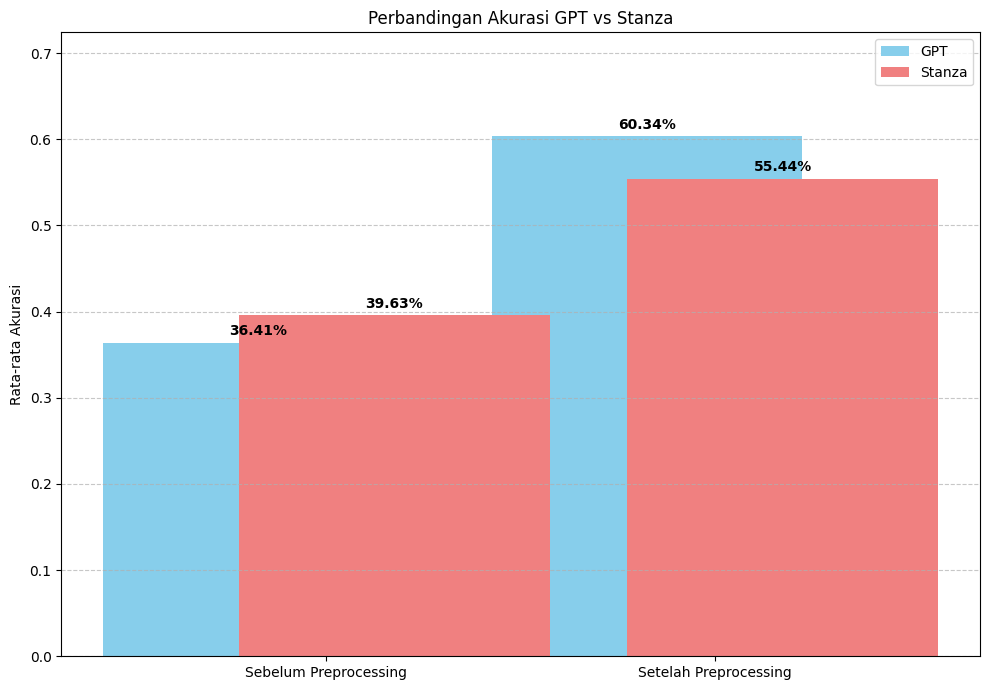

In [41]:
labels = ['Sebelum Preprocessing', 'Setelah Preprocessing']
gpt_accuracy_means = [avg_gpt_before_preprocessing, avg_gpt_after_preprocessing]
stanza_accuracy_means = [avg_stanza_before_preprocessing, avg_stanza_after_preprocessing]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, gpt_accuracy_means, label='GPT', color='skyblue')
rects2 = ax.bar(x + width/2, stanza_accuracy_means, label='Stanza', color='lightcoral')

ax.set_ylabel('Rata-rata Akurasi')
ax.set_title('Perbandingan Akurasi GPT vs Stanza')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt=lambda x: f'{x:.2%}', fontweight='bold')
ax.bar_label(rects2, padding=3, fmt=lambda x: f'{x:.2%}', fontweight='bold')

ax.set_ylim(0, max(max(gpt_accuracy_means), max(stanza_accuracy_means)) * 1.2)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)

fig.tight_layout()
plt.show()


Kode di atas menampilkan grafik batang untuk membandingkan rata-rata akurasi GPT dan Stanza sebelum dan sesudah preprocessing

In [42]:
def extract_verb(notation_string: str) -> list:
  if not isinstance(notation_string, str):
    return []
  
  verb_find = []
  tokens = notation_string.strip().split(' ')

  for token in tokens:
    if '/' in token:
      parts = token.rsplit('/', 1)
      if len(parts) == 2:
        word, tag = parts
        if  tag.startswith('V'):
          verb_find.append(word)
  
  return verb_find

Fungsi di atas mengekstrak kata kerja dari string berformat kata/tag dengan mencari token yang tag-nya diawali huruf 'V'. Jika ditemukan, katanya dimasukkan ke dalam list dan dikembalikan. Jika input bukan string, hasilnya list kosong.

In [43]:
try:
  df_full_notation = pd.read_csv('./data/dataset-post-taging-dan-taksnomi-bloom.csv')
  print(f"Berhasil membaca file")
except FileNotFoundError:
  print("ERROR: File tidak ditemukan!")

Berhasil membaca file


Kode di atas membaca dataset dari post tagging dan taksonomi bloom. Jika berhasil, akan menampilkan pesan "Berhasil membaca file", dan jika file tidak ditemukan, akan menampilkan "ERROR: File tidak ditemukan!".

In [44]:
df_full_notation['list_verb'] = df_full_notation['gpt'].apply(extract_verb)
df_display = ['soal', 'list_verb', 'level', 'taksonomi_bloom']
df_full_notation = df_full_notation[df_display]
df_full_notation.head()

,soal,list_verb,level,taksonomi_bloom
0,Bagian dari bidang biologi yang membutuhkan pe...,[membutuhkan],3,C1-Mengingat
1,"Dalam studi biologi, penggunaan mikroskop dipe...","[diperlukan, mempelajari]",1,C1-Mengingat
2,Ilmu biologi yang membutuhkan penggunaan mikro...,"[membutuhkan, mengkaji]",3,C1-Mengingat
3,Cabang biologi yang mendorong peneliti untuk m...,"[mendorong, menghasilkan]",2,C2-Memahami
4,Cabang ilmu biologi yang menjadi dasar bagi pe...,"[menjadi, mengembangkan]",2,C2-Memahami


Kode di atas berguna untuk mengekstrak kata kerja dari kolom gpt dalam dataset, lalu menampilkannya bersama informasi soal, level, dan taksonomi_bloom. Tujuannya adalah untuk menganalisis keterkaitan antara kata kerja dalam soal dengan level kognitif berdasarkan Taksonomi Bloom, sehingga dapat membantu dalam klasifikasi atau evaluasi kualitas soal.

In [45]:
try:
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  print("Berhasil membuat stemmer Sastrawi")
except NameError:
  print("ERROR: Sastrawi library tidak ditemukan!")

Berhasil membuat stemmer Sastrawi


Kode di atas mencoba membuat variabel stemmer, yang digunakan untuk stemming (mengubah kata berimbuhan menjadi bentuk dasar) dalam Bahasa Indonesia. 

In [46]:
def stem_list_verb(list_verb: list):
  if not isinstance(list_verb, list):
    return []
  return [stemmer.stem(verb) for verb in list_verb]


Fungsi di atas digunakan untuk melakukan stemming terhadap daftar kata kerja. Jika input bukan list, fungsi mengembalikan list kosong. Jika valid, setiap kata dalam list akan diproses menggunakan stemmer Sastrawi untuk diubah ke bentuk dasarnya, lalu hasilnya dikembalikan sebagai list baru.

In [47]:
df_full_notation['list_verb_stemmed'] = df_full_notation['list_verb'].apply(stem_list_verb)

# Membuat duplikat dari df_full_notation untuk menerapkan saran setelah presentasi
df_full_notation_duplicate = df_full_notation.copy()

df_full_notation[['soal', 'list_verb', 'list_verb_stemmed', 'level', 'taksonomi_bloom']].head()

,soal,list_verb,list_verb_stemmed,level,taksonomi_bloom
0,Bagian dari bidang biologi yang membutuhkan pe...,[membutuhkan],[butuh],3,C1-Mengingat
1,"Dalam studi biologi, penggunaan mikroskop dipe...","[diperlukan, mempelajari]","[perlu, ajar]",1,C1-Mengingat
2,Ilmu biologi yang membutuhkan penggunaan mikro...,"[membutuhkan, mengkaji]","[butuh, kaji]",3,C1-Mengingat
3,Cabang biologi yang mendorong peneliti untuk m...,"[mendorong, menghasilkan]","[dorong, hasil]",2,C2-Memahami
4,Cabang ilmu biologi yang menjadi dasar bagi pe...,"[menjadi, mengembangkan]","[jadi, kembang]",2,C2-Memahami


Kode di atas menambahkan kolom list_verb_stemmed ke dalam DataFrame df_full_notation dengan menerapkan fungsi stem_list_verb pada kolom list_verb. Tujuannya adalah mengubah setiap kata kerja menjadi bentuk dasar menggunakan stemmer Sastrawi. 

In [48]:
bloom_keywords = {
    "C1": ["mengutip", "menyebutkan", "menjelaskan", "menggambar", "membilang", "mengidentifikasi", "mendaftar", "menunjukkan", "memberi label", "memberi indeks", "memasangkan", "menamai", "menandai", "membaca", "menyadari", "menghafal", "meniru", "mencatat", "mengulang", "mereproduksi", "meninjau", "memilih", "menyatakan", "mempelajari", "mentabulasi", "memberi kode", "menelusuri", "menulis", "mengenal", "melihat", "menyimpan", "mengisi", "memperhatikan"],
    "C2": ["memperkirakan", "menjelaskan", "mengkategorikan", "mencirikan", "merinci", "mengasosiasikan", "membandingkan", "menghitung", "mengubah", "mempertahankan", "menguraikan", "menjalin", "membedakan", "mendiskusikan", "mencontohkan", "mengemukakan", "mempolakan", "memperluas", "menyimpulkan", "meramalkan", "merangkum", "menjabarkan", "mengartikan", "membahas", "mengelompokkan", "memberi", "mengisahkan", "menceritakan", "menyerap"],
    "C3": ["menugaskan", "mengurutkan", "menentukan", "menerapkan", "menyesuaikan", "mengkalkulasi", "memodifikasi", "mengklasifikasi", "menghitung", "membangun", "membiasakan", "mencegah", "menentukan", "menggambarkan", "menggunakan", "menilai", "melatih", "menggali", "mengemukakan", "mengkonsultasi", "memecahkan", "melakukan", "mentabulasi", "mempersoalkan", "melaksanakan", "mengerjakan", "memfungsikan", "menanggulangi"],
    "C4": ["menganalisis", "mengaudit", "memecahkan", "menegaskan", "mendeteksi", "mendiagnosis", "menyeleksi", "merinci", "menominasikan", "mendiagramkan", "megkorelasikan", "menguji", "mencerahkan", "menjelajah", "membagankan", "menyimpulkan", "menemukan", "menelaah", "memaksimalkan", "memerintahkan", "mengedit", "mengaitkan", "memilih", "mengukur", "menghubungkan", "mengkaji", "membatasi"],
    "C5": ["membandingkan", "menyimpulkan", "menilai", "mengarahkan", "mengkritik", "menimbang", "memutuskan", "memisahkan", "memprediksi", "memperjelas", "menugaskan", "menafsirkan", "mempertahankan", "memerinci", "mengukur", "merangking", "membuktikan", "memvalidasi", "mendukung", "memilih", "proyeksi", "menganggap"],
    "C6": ["membangun", "mengabstraksikan", "mengatur", "menganimasi", "mengumpulkan", "mengkategorikan", "mengkombinasikan", "menyusun", "mengarang", "menciptakan", "mendesain", "mengembangkan", "merumuskan", "memimpin", "mengelola", "mengorganisir", "merencanakan", "mempersiapkan", "memproduksi", "mengusulkan", "merancang", "merekonstruksi", "membuat", "membentuk"]
}

bloom_keywords_stemmed = {}
for level, keywords in bloom_keywords.items():
  stemmed_list = [stemmer.stem(word) for word in keywords]
  bloom_keywords_stemmed[level] = stemmed_list

print(f"Contoh hasil stemming C1  : {bloom_keywords_stemmed['C1'][:3]}")
print(f"Contoh hasil stemming C2  : {bloom_keywords_stemmed['C2'][:3]}")
print(f"Contoh hasil stemming C3  : {bloom_keywords_stemmed['C3'][:3]}")
print(f"Contoh hasil stemming C4  : {bloom_keywords_stemmed['C4'][:3]}")
print(f"Contoh hasil stemming C5  : {bloom_keywords_stemmed['C5'][:3]}")
print(f"Contoh hasil stemming C6  : {bloom_keywords_stemmed['C6'][:3]}")


Contoh hasil stemming C1  : ['kutip', 'sebut', 'jelas']
Contoh hasil stemming C2  : ['kira', 'jelas', 'kategori']
Contoh hasil stemming C3  : ['tugas', 'urut', 'tentu']
Contoh hasil stemming C4  : ['analis', 'audit', 'pecah']
Contoh hasil stemming C5  : ['banding', 'simpul', 'nilai']
Contoh hasil stemming C6  : ['bangun', 'abstraksi', 'atur']


Kode di atas melakukan proses stemming terhadap daftar kata kerja dari setiap level taksonomi Bloom (C1 hingga C6) menggunakan stemmer Sastrawi. Setiap kata kerja dari bloom_keywords diubah ke bentuk dasarnya dan disimpan dalam dictionary bloom_keywords_stemmed sesuai levelnya. Ini berguna untuk mempermudah pencocokan kata kerja dalam bentuk dasar dengan daftar kata kerja dari soal atau teks, sehingga bisa mengklasifikasikan level kognitif berdasarkan kemunculan kata kerja tertentu. Hasil stemming dari beberapa kata di setiap level ditampilkan.

In [49]:
def classification_taksonomi_by_verb(list_verb_stemmed: list, kamus_bloom_stemmed: dict) -> str:
  if not list_verb_stemmed:
    return "Tidak Terklasifikasi"
  
  set_verb_soal = set(list_verb_stemmed)
  score_compatibility = {}
  for level, list_keyword in kamus_bloom_stemmed.items():
    set_keyword_bloom = set(list_keyword)
    total_compatibility = len(set_verb_soal.intersection(set_keyword_bloom))
    score_compatibility[level] = total_compatibility
  
  if max(score_compatibility.values()) == 0:
    return "Tidak Terklasifikasi"
  
  max_score_compatibility = max(score_compatibility.values())
  best_level = [level for level, score in score_compatibility.items() if score == max_score_compatibility]
  final_prediction = sorted(best_level)[-1]

  return final_prediction

Fungsi di atas digunakan untuk menentukan level taksonomi Bloom C1 sampai C6 dari suatu soal berdasarkan daftar kata kerja yang telah distemming. Fungsi ini bekerja dengan membandingkan kata kerja dari soal (list_verb_stemmed) dengan kamus kata kerja Bloom yang sudah distem (kamus_bloom_stemmed)

In [50]:
df_full_notation['prediction_taksonomi_bloom'] = df_full_notation['list_verb_stemmed'].apply(
      lambda x: classification_taksonomi_by_verb(x, bloom_keywords_stemmed)
    )

df_full_notation['ground_truth_taksonomi_bloom'] = df_full_notation['taksonomi_bloom'].str.split('-').str[0]
df_full_notation[['soal', 'list_verb_stemmed', 'prediction_taksonomi_bloom', 'ground_truth_taksonomi_bloom']].head()

,soal,list_verb_stemmed,prediction_taksonomi_bloom,ground_truth_taksonomi_bloom
0,Bagian dari bidang biologi yang membutuhkan pe...,[butuh],Tidak Terklasifikasi,C1
1,"Dalam studi biologi, penggunaan mikroskop dipe...","[perlu, ajar]",C1,C1
2,Ilmu biologi yang membutuhkan penggunaan mikro...,"[butuh, kaji]",C4,C1
3,Cabang biologi yang mendorong peneliti untuk m...,"[dorong, hasil]",Tidak Terklasifikasi,C2
4,Cabang ilmu biologi yang menjadi dasar bagi pe...,"[jadi, kembang]",C6,C2


Kode tersebut digunakan untuk melakukan klasifikasi level taksonomi Bloom pada setiap soal berdasarkan kata kerja hasil stemming, serta membandingkan hasil prediksi dengan label ground truth

In [51]:
eval_df = df_full_notation[df_full_notation['prediction_taksonomi_bloom'] != 'Tidak Terklasifikasi']
accuracy = accuracy_score(eval_df['ground_truth_taksonomi_bloom'], eval_df['prediction_taksonomi_bloom'])
print(f"Akurasi Keseluruhan: {accuracy:.2%}\n")

Akurasi Keseluruhan: 20.20%



Kode di atas digunakan untuk menghitung akurasi dari hasil prediksi klasifikasi taksonomi Bloom berdasarkan kata kerja yang telah distemming

In [52]:
all_labels = sorted(list(set(eval_df['ground_truth_taksonomi_bloom']) | set(eval_df['prediction_taksonomi_bloom'])))
print(classification_report(
    eval_df['ground_truth_taksonomi_bloom'], 
    eval_df['prediction_taksonomi_bloom'], 
    labels=all_labels, 
    zero_division=0
))

              precision    recall  f1-score   support

          C1       0.75      0.25      0.37        61
          C2       0.45      0.15      0.23        33
          C3       0.00      0.00      0.00         0
          C4       0.00      0.00      0.00         3
          C5       0.00      0.00      0.00         2
          C6       0.00      0.00      0.00         0

    accuracy                           0.20        99
   macro avg       0.20      0.07      0.10        99
weighted avg       0.61      0.20      0.30        99



Kode di atas digunakan untuk menampilkan precision, recall, f1-score, dan support dari klasifikasi taksonomi Bloom berdasarkan hasil prediksi dan label sebenarnya

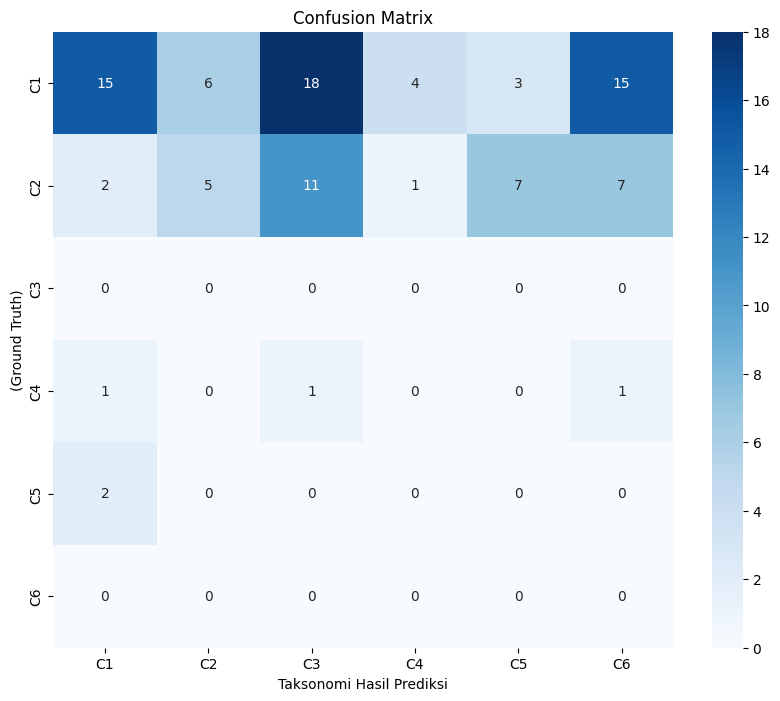

In [53]:
cm = confusion_matrix(
    eval_df['ground_truth_taksonomi_bloom'], 
    eval_df['prediction_taksonomi_bloom'], 
    labels=all_labels
)
cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('(Ground Truth)')
plt.xlabel('Taksonomi Hasil Prediksi')
plt.show()

Kode di atas berfungsi untuk menampilkan confusion matrix dari hasil klasifikasi taksonomi Bloom. Pertama, confusion_matrix dari scikit-learn digunakan untuk menghitung jumlah prediksi yang benar dan salah untuk setiap label berdasarkan data ground truth dan prediksi. Confusion matrix tersebut menunjukkan performa model dalam mengklasifikasikan soal berdasarkan taksonomi Bloom C1 sampai C6, di mana baris merepresentasikan ground truth dan kolom merepresentasikan label hasil prediksi. Nilai diagonal (seperti C1 ke C1 sebanyak 15 dan C2 ke C2 sebanyak 5) menunjukkan prediksi yang benar, sedangkan nilai di luar diagonal menunjukkan kesalahan prediksi. Terlihat bahwa model sering salah mengklasifikasikan soal C1 dan C2 menjadi C3 (masing-masing sebanyak 18 dan 11 soal), menunjukkan adanya kecenderungan over-prediction pada label C3. Selain itu, model tidak mampu mengenali label C3 dengan benar sama sekali (semua nilai pada baris C3 adalah nol), dan hanya sedikit soal dari C4 dan C5 yang diprediksi dengan benar. 

In [54]:
df_failed_classified = df_full_notation[df_full_notation['prediction_taksonomi_bloom'] == 'Tidak Terklasifikasi'].copy()
if not df_failed_classified.empty:
    all_verb_failed = [verb for list_verb in df_failed_classified['list_verb_stemmed'] for verb in list_verb]
    verb_frequency = pd.Series(all_verb_failed).value_counts()
    print(verb_frequency.head().to_string())
else:
    print("Tidak ada soal yang tidak terklasifikasi.")


adalah    61
masuk     10
milik      9
sebab      8
hasil      7


Kode di atas digunakan untuk menganalisis soal-soal yang tidak berhasil dipetakan ke dalam taksonomi Bloom. Hasilnya menunjukkan bahwa kata-kata seperti adalah muncul sebanyak 61 kali, masuk 10 kali, milik 9 kali, sebab 8 kali, dan hasil sebanyak 7 kali. Kata kata itu merupakan kata yang sering muncul pada soal yang gagal diklasifikasikan

In [55]:
verbs_by_level = df_full_notation.groupby('level')['list_verb_stemmed'].sum()

Kode di atas berfungsi untuk mengelompokkan data berdasarkan kolom level yaitu level taksonomi Bloom seperti C1 sampai C6, kemudian menjumlahkan  semua daftar kata kerja hasil stemming dari setiap kelompok. K

In [56]:
def analyze_level_profile(verbs_list, bloom_dict):
    if not verbs_list: return {}
    unique_verbs_in_level = set(verbs_list)
    total_unique_verbs = len(unique_verbs_in_level)
    if total_unique_verbs == 0: return {}
    
    distribution = {}
    for bloom_level, bloom_keywords in bloom_dict.items():
        bloom_keywords_set = set(bloom_keywords)
        matches = len(unique_verbs_in_level.intersection(bloom_keywords_set))
        percentage = (matches / total_unique_verbs) * 100
        distribution[bloom_level] = percentage
    return distribution

Kode di atas berfungsi untuk menghitung distribusi persentase kecocokan kata kerja terhadap setiap level dalam taksonomi Bloom berdasarkan kamus kata kunci yang telah distemming. Fungsi ini membandingkan kata kerja unik yang diberikan dengan daftar kata kunci dari masing-masing level Bloom, lalu menghitung berapa persen kata kerja tersebut cocok dengan setiap level. Hasilnya berupa dictionary yang menunjukkan tingkat kesesuaian kata kerja terhadap tiap level C1 sampai C6 dalam bentuk persentase.

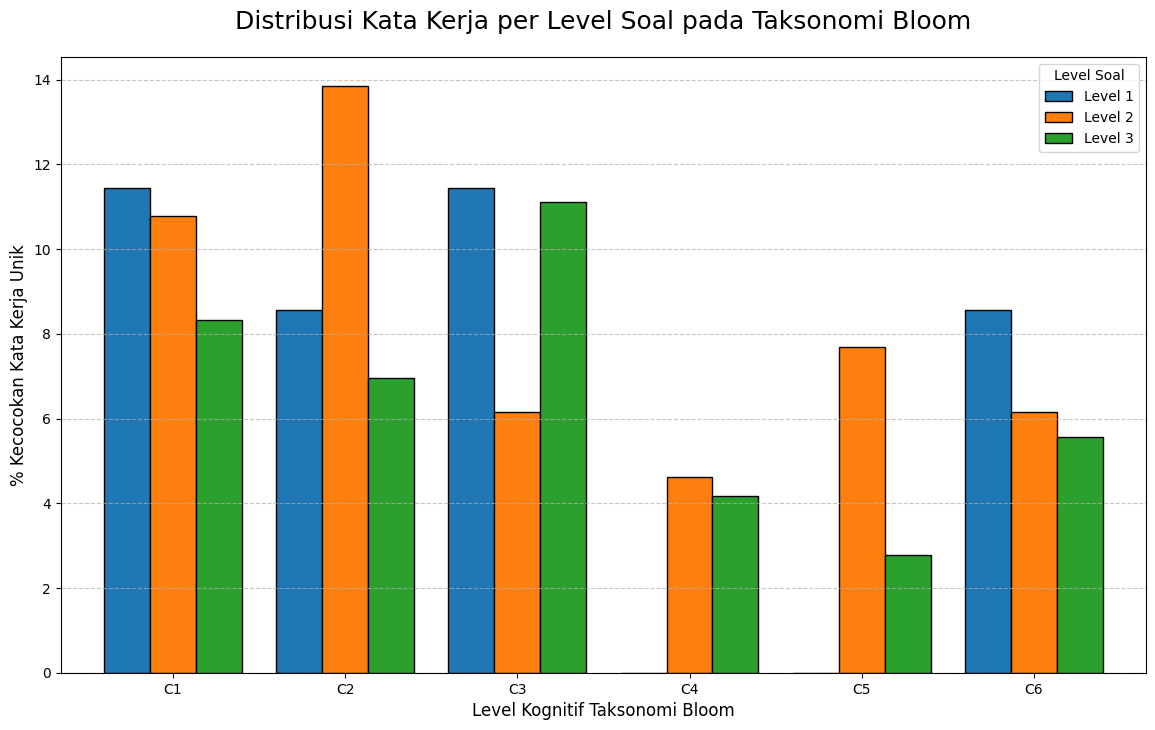

In [57]:
results_for_plotting = {}
for level, all_verbs in verbs_by_level.items():
    if all_verbs:
        bloom_distribution = analyze_level_profile(all_verbs, bloom_keywords_stemmed)
        # Simpan hasil distribusi ke dictionary utama
        results_for_plotting[f'Level {level}'] = bloom_distribution

plot_df = pd.DataFrame(results_for_plotting).sort_index()

# Membuat plot
if not plot_df.empty:
    plot_df.plot(
        kind='bar',
        figsize=(14, 8),
        width=0.8,
        edgecolor='black'
    )
    
    plt.title('Distribusi Kata Kerja per Level Soal pada Taksonomi Bloom', fontsize=18, pad=20)
    plt.ylabel('% Kecocokan Kata Kerja Unik', fontsize=12)
    plt.xlabel('Level Kognitif Taksonomi Bloom', fontsize=12)
    plt.xticks(rotation=0) # Agar label C1, C2, dst. tidak miring
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Level Soal')
    
    plt.show()
else:
    print("Tidak ada data untuk dibuat grafik.")

Kode di atas berfungsi untuk menghitung dan memvisualisasikan distribusi persentase kecocokan kata kerja unik dari setiap level soal terhadap setiap level dalam taksonomi Bloom. Dari Grafik di atas dapat di ambil kesimpulan bahwa distribusi kata kerja unik pada setiap level soal (Level 1, Level 2, Level 3) menunjukkan kecenderungan tersebar pada level kognitif C1, C2, dan C3 dalam taksonomi Bloom. Hal ini terlihat dari persentase kecocokan yang relatif tinggi pada ketiga level tersebut dibandingkan dengan C4, C5, dan C6 yang memiliki persentase lebih rendah. Artinya, sebagian besar soal cenderung mengandung kata kerja yang merepresentasikan kemampuan kognitif tingkat rendah hingga menengah, seperti mengingat, memahami, dan menerapkan, sedangkan kemampuan analisis, evaluasi, dan mencipta masih kurang terwakili dalam soal-soal yang dianalisis.

In [58]:
for level, all_verbs in verbs_by_level.items():
    print(f"\n=== Level: {level} ===")   
    
    if not all_verbs:
        print("Tidak ditemukan kata kerja untuk level ini.")
        continue

    verb_counts = Counter(all_verbs)
    print("\n10 Kata Kerja (Stemmed) Paling Umum:")
    for verb, count in verb_counts.most_common(10):
        print(f"- {verb}: {count} kali")

    bloom_distribution = analyze_level_profile(all_verbs, bloom_keywords_stemmed)

    print("\nDistribusi pada Taksonomi Bloom (% Kata Kerja Unik di Level Ini yang Cocok):")
    if bloom_distribution:
        sorted_distribution = sorted(bloom_distribution.items())
        for bloom_level, percentage in sorted_distribution:
            print(f"- {bloom_level}: {percentage:.2f}%")
    else:
        print("Tidak ada kecocokan dengan kamus Taksonomi Bloom.")



=== Level: 1 ===

10 Kata Kerja (Stemmed) Paling Umum:
- adalah: 16 kali
- dapat: 6 kali
- sebut: 4 kali
- perhati: 3 kali
- ajar: 2 kali
- guna: 2 kali
- bentuk: 2 kali
- hidup: 2 kali
- bisa: 2 kali
- milik: 2 kali

Distribusi pada Taksonomi Bloom (% Kata Kerja Unik di Level Ini yang Cocok):
- C1: 11.43%
- C2: 8.57%
- C3: 11.43%
- C4: 0.00%
- C5: 0.00%
- C6: 8.57%

=== Level: 2 ===

10 Kata Kerja (Stemmed) Paling Umum:
- adalah: 46 kali
- dapat: 11 kali
- laku: 9 kali
- masuk: 8 kali
- sebut: 8 kali
- sebab: 8 kali
- bentuk: 6 kali
- hidup: 6 kali
- hasil: 5 kali
- jadi: 5 kali

Distribusi pada Taksonomi Bloom (% Kata Kerja Unik di Level Ini yang Cocok):
- C1: 10.77%
- C2: 13.85%
- C3: 6.15%
- C4: 4.62%
- C5: 7.69%
- C6: 6.15%

=== Level: 3 ===

10 Kata Kerja (Stemmed) Paling Umum:
- adalah: 42 kali
- laku: 7 kali
- ada: 6 kali
- milik: 6 kali
- sebab: 6 kali
- jadi: 5 kali
- sebut: 5 kali
- masuk: 5 kali
- perlu: 4 kali
- bisa: 4 kali

Distribusi pada Taksonomi Bloom (% Kata Kerja 

Kode di atas digunakan untuk menganalisis kata kerja yang paling sering digunakan dalam soal berdasarkan level soal, serta mengukur kesesuaian kata kerja tersebut terhadap level kognitif Taksonomi Bloom. Berdasarkan analisis terhadap distribusi kata kerja dalam soal dari tiga level yang berbeda, ditemukan bahwa kata kerja yang paling sering muncul adalah "adalah", "dapat", "laku", "sebut", dan "bentuk". Distribusi persentase kecocokan kata kerja unik terhadap kategori taksonomi Bloom menunjukkan bahwa dominasi utama berada pada level kognitif rendah hingga menengah, yaitu C1 (mengingat), C2 (memahami), dan C3 (menerapkan), dengan persentase tertinggi masing-masing mencapai sekitar 11–14%. Sementara itu, level kognitif tinggi seperti C4 (menganalisis), C5 (mengevaluasi), dan C6 (mencipta) menunjukkan persentase yang jauh lebih rendah, bahkan pada beberapa level soal tidak ditemukan sama sekali kecocokan dengan kategori tersebut. Hal ini mengindikasikan bahwa sebagian besar soal cenderung menekankan pada pengujian pengetahuan dasar dan pemahaman, serta masih kurang mengeksplorasi keterampilan berpikir tingkat tinggi yang lebih kompleks.


# Tambahan Setelah Presentasi - Implementasi Saran 

In [59]:
# Menghitung jumlah kata kerja di setiap soal
total_token_verb = df_full_notation['list_verb_stemmed'].apply(len).sum()

all_verbs_list = [verb for sublist in df_full_notation['list_verb_stemmed'] for verb in sublist]
total_unique_verbs = len(set(all_verbs_list))

print(f"Total Token Kata Kerja (Stemmed) di Seluruh Dataset: {total_token_verb}")
print(f"Jumlah Kata Kerja Unik (Stemmed) di Seluruh Dataset: {total_unique_verbs}")

Total Token Kata Kerja (Stemmed) di Seluruh Dataset: 444
Jumlah Kata Kerja Unik (Stemmed) di Seluruh Dataset: 106


Kode di atas menghitung total kata kerja (stemmed) dan jumlah kata kerja unik. Kolom list_verb_stemmed berisi daftar kata kerja per soal. Total token dihitung dari jumlah seluruh kata kerja, sedangkan jumlah unik dihitung dari banyaknya kata kerja berbeda setelah digabung dan diubah menjadi himpunan

In [60]:
# menghapus kata "adalah" dari dataset
df_full_notation_duplicate['list_verb_stemmed'] = df_full_notation_duplicate['list_verb_stemmed'].apply(
    lambda verb_list: [verb for verb in verb_list if verb != 'adalah']
)

Kode di atas berfungsi untuk menghapus kata "adalah" dari setiap daftar kata kerja yang terdapat dalam kolom list_verb_stemmed di mana hanya kata kerja yang tidak sama dengan "adalah" yang akan di gunakan,

In [61]:
# melihat apakah ada perbedaan hasil klasifikasi
df_full_notation_duplicate['prediction_taksonomi_bloom'] = df_full_notation_duplicate['list_verb_stemmed'].apply(
      lambda x: classification_taksonomi_by_verb(x, bloom_keywords_stemmed)
    )

df_full_notation_duplicate['ground_truth_taksonomi_bloom'] = df_full_notation_duplicate['taksonomi_bloom'].str.split('-').str[0]
df_full_notation_duplicate[['soal', 'list_verb_stemmed', 'prediction_taksonomi_bloom', 'ground_truth_taksonomi_bloom']].head()

,soal,list_verb_stemmed,prediction_taksonomi_bloom,ground_truth_taksonomi_bloom
0,Bagian dari bidang biologi yang membutuhkan pe...,[butuh],Tidak Terklasifikasi,C1
1,"Dalam studi biologi, penggunaan mikroskop dipe...","[perlu, ajar]",C1,C1
2,Ilmu biologi yang membutuhkan penggunaan mikro...,"[butuh, kaji]",C4,C1
3,Cabang biologi yang mendorong peneliti untuk m...,"[dorong, hasil]",Tidak Terklasifikasi,C2
4,Cabang ilmu biologi yang menjadi dasar bagi pe...,"[jadi, kembang]",C6,C2


Kode tersebut digunakan untuk membandingkan hasil klasifikasi taksonomi Bloom dengan label aslinya yang sudah tersedia di data. Proses dimulai dengan mengklasifikasikan setiap soal berdasarkan kata kerja yang telah distem menggunakan fungsi tertentu yang mencocokkan kata kerja tersebut dengan daftar kata kunci dari taksonomi Bloom. Selanjutnya, label asli dari taksonomi Bloom diambil dari bagian depan informasi label yang ada, yaitu sebelum tanda pemisah. Terakhir, ditampilkan sebagian data yang memuat soal, daftar kata kerja hasil stemming, hasil klasifikasi otomatis, dan label asli untuk melihat apakah ada perbedaan antara hasil klasifikasi dan label yang sebenarnya

In [62]:
df_failed_classified = df_full_notation_duplicate[df_full_notation_duplicate['prediction_taksonomi_bloom'] == 'Tidak Terklasifikasi'].copy()
if not df_failed_classified.empty:
    all_verb_failed = [verb for list_verb in df_failed_classified['list_verb_stemmed'] for verb in list_verb]
    verb_frequency = pd.Series(all_verb_failed).value_counts()
    print(verb_frequency.head().to_string())
else:
    print("Tidak ada soal yang tidak terklasifikasi.")


masuk    10
milik     9
sebab     8
hasil     7
ada       6


Kode di atas digunakan untuk menganalisis soal-soal yang tidak berhasil diklasifikasikan ke dalam taksonomi Bloom. Pertama, dibuat salinan data yang hanya berisi soal-soal dengan hasil klasifikasi otomatis berupa "Tidak Terklasifikasi". Jika data tersebut tidak kosong, maka seluruh kata kerja dari soal-soal tersebut dikumpulkan, lalu dihitung frekuensinya menggunakan value_counts dari pandas untuk mengetahui kata kerja apa saja yang paling sering muncul dalam soal yang gagal diklasifikasikan

In [63]:
for level, all_verbs in verbs_by_level.items():
    print(f"\n=== Level: {level} ===")   
    
    if not all_verbs:
        print("Tidak ditemukan kata kerja untuk level ini.")
        continue

    verb_counts = Counter(all_verbs)
    print("\n10 Kata Kerja (Stemmed) Paling Umum:")
    for verb, count in verb_counts.most_common(10):
        print(f"- {verb}: {count} kali")

    bloom_distribution = analyze_level_profile(all_verbs, bloom_keywords_stemmed)

    print("\nDistribusi pada Taksonomi Bloom (% Kata Kerja Unik di Level Ini yang Cocok):")
    if bloom_distribution:
        sorted_distribution = sorted(bloom_distribution.items())
        for bloom_level, percentage in sorted_distribution:
            print(f"- {bloom_level}: {percentage:.2f}%")
    else:
        print("Tidak ada kecocokan dengan kamus Taksonomi Bloom.")



=== Level: 1 ===

10 Kata Kerja (Stemmed) Paling Umum:
- adalah: 16 kali
- dapat: 6 kali
- sebut: 4 kali
- perhati: 3 kali
- ajar: 2 kali
- guna: 2 kali
- bentuk: 2 kali
- hidup: 2 kali
- bisa: 2 kali
- milik: 2 kali

Distribusi pada Taksonomi Bloom (% Kata Kerja Unik di Level Ini yang Cocok):
- C1: 11.43%
- C2: 8.57%
- C3: 11.43%
- C4: 0.00%
- C5: 0.00%
- C6: 8.57%

=== Level: 2 ===

10 Kata Kerja (Stemmed) Paling Umum:
- adalah: 46 kali
- dapat: 11 kali
- laku: 9 kali
- masuk: 8 kali
- sebut: 8 kali
- sebab: 8 kali
- bentuk: 6 kali
- hidup: 6 kali
- hasil: 5 kali
- jadi: 5 kali

Distribusi pada Taksonomi Bloom (% Kata Kerja Unik di Level Ini yang Cocok):
- C1: 10.77%
- C2: 13.85%
- C3: 6.15%
- C4: 4.62%
- C5: 7.69%
- C6: 6.15%

=== Level: 3 ===

10 Kata Kerja (Stemmed) Paling Umum:
- adalah: 42 kali
- laku: 7 kali
- ada: 6 kali
- milik: 6 kali
- sebab: 6 kali
- jadi: 5 kali
- sebut: 5 kali
- masuk: 5 kali
- perlu: 4 kali
- bisa: 4 kali

Distribusi pada Taksonomi Bloom (% Kata Kerja 

Kode di atas berfungsi untuk menganalisis distribusi dan frekuensi kata kerja (stemmed) dalam soal berdasarkan level taksonomi tertentu, serta mengevaluasi kecocokannya dengan daftar kata kunci taksonomi Bloom. Hasilnya menunjukkan bahwa setelah preprocessing—termasuk penghapusan kata umum seperti "adalah"—akurasi klasifikasi meningkat, dari rata-rata sekitar 36–39% menjadi 55–60%. Meskipun begitu, akurasi keseluruhan klasifikasi tetap sama dengan hasil sebelumnya yaitu 20.20%, dengan banyak soal yang tidak berhasil diklasifikasikan secara tepat. Selain itu, distribusi kata kerja menunjukkan bahwa banyak kata yang sering muncul justru tidak spesifik terhadap satu level taksonomi, sehingga menyulitkan proses klasifikasi otomatis.

In [64]:
# perbandingan akurasi sebelum dan sesudah

df_full_notation['predicted_level'] = df_full_notation['list_verb_stemmed'].apply(lambda x: classification_taksonomi_by_verb(x, bloom_keywords_stemmed))
eval_ori = df_full_notation[df_full_notation['predicted_level'] != 'Tidak Terklasifikasi']
accuracy_ori = accuracy_score(eval_ori['ground_truth_taksonomi_bloom'], eval_ori['predicted_level'])


df_full_notation_duplicate['predicted_level'] = df_full_notation_duplicate['list_verb_stemmed'].apply(lambda x: classification_taksonomi_by_verb(x, bloom_keywords_stemmed))
eval_duplicate = df_full_notation_duplicate[df_full_notation_duplicate['predicted_level'] != 'Tidak Terklasifikasi']
accuracy_duplicate = accuracy_score(eval_duplicate['ground_truth_taksonomi_bloom'], eval_duplicate['predicted_level'])

print(f"Akurasi SEBELUM pembersihan kata 'adalah': {accuracy_ori:.2%}")
print(f"Akurasi SESUDAH pembersihan kata 'adalah': {accuracy_duplicate:.2%}\n")

Akurasi SEBELUM pembersihan kata 'adalah': 20.20%
Akurasi SESUDAH pembersihan kata 'adalah': 20.20%



Kode di atas berfungsi untuk menampilkan akurasi ketika sebelum kata adalah di bersihkan dan sesudah kata adalah di bersihkan waalupun begitu hasilnya tetap 20,20 %

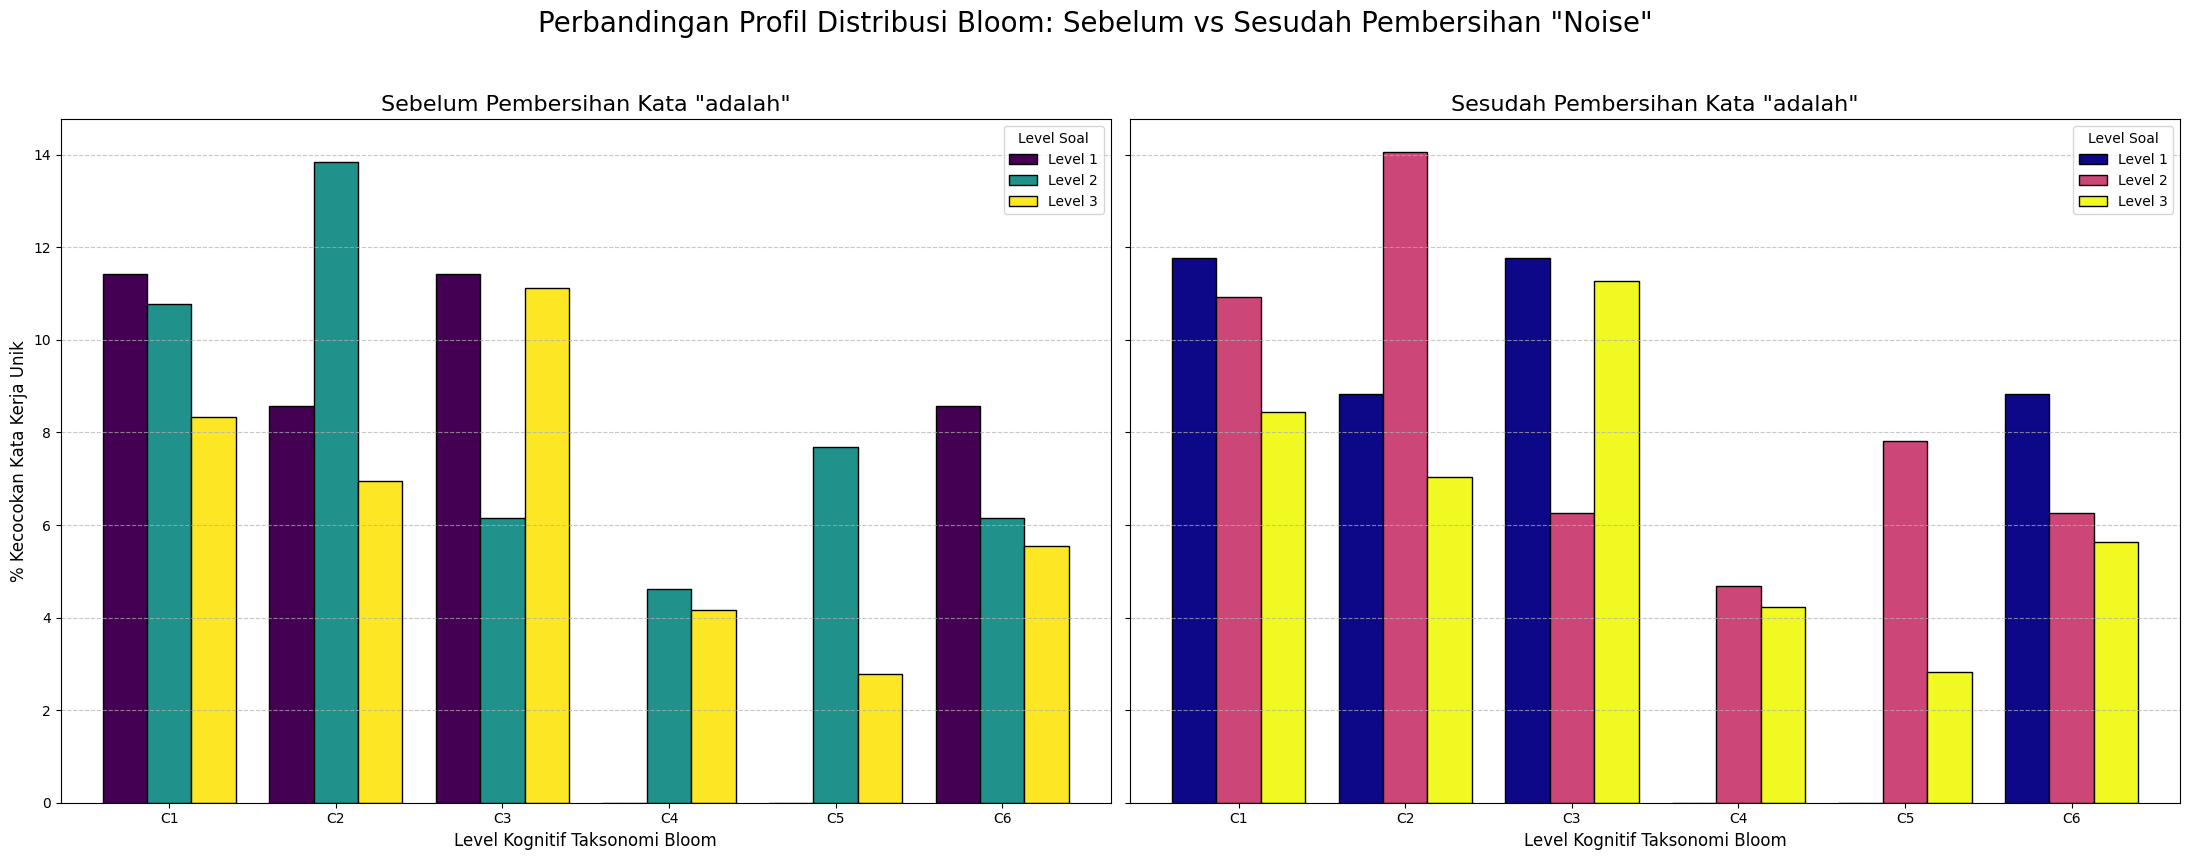

In [65]:
verbs_by_level_ori = df_full_notation.groupby('level')['list_verb_stemmed'].sum()
results_ori = {}
for level, all_verbs in verbs_by_level_ori.items():
    if all_verbs:
        results_ori[f'Level {level}'] = analyze_level_profile(all_verbs, bloom_keywords_stemmed)
plot_df_ori = pd.DataFrame(results_ori).sort_index()

verbs_by_level_duplicate = df_full_notation_duplicate.groupby('level')['list_verb_stemmed'].sum()
results_duplicate = {}
for level, all_verbs in verbs_by_level_duplicate.items():
    if all_verbs:
        results_duplicate[f'Level {level}'] = analyze_level_profile(all_verbs, bloom_keywords_stemmed)
plot_df_duplicate = pd.DataFrame(results_duplicate).sort_index()

fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=True)
fig.suptitle('Perbandingan Profil Distribusi Bloom: Sebelum vs Sesudah Pembersihan "Noise"', fontsize=20)

# Plot untuk data SEBELUM
plot_df_ori.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black', colormap='viridis')
axes[0].set_title('Sebelum Pembersihan Kata "adalah"', fontsize=16)
axes[0].set_ylabel('% Kecocokan Kata Kerja Unik', fontsize=12)
axes[0].set_xlabel('Level Kognitif Taksonomi Bloom', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Level Soal')

# Plot untuk data SESUDAH
plot_df_duplicate.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black', colormap='plasma')
axes[1].set_title('Sesudah Pembersihan Kata "adalah"', fontsize=16)
axes[1].set_xlabel('Level Kognitif Taksonomi Bloom', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend(title='Level Soal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

Kode di atas bergungsi untuk menampilkan level kognitif taksonomi bloom di mana terdapat dua tabel yang menampilkan ketika sebelum pembersihan kata adalah dan sesudah pembersihan kata adalah walaupun begitu dapat dilihat hasil yang di dapat tetap sama

In [ ]:
print("="*60)
print("--- Statistik Deskriptif Tambahan untuk Laporan ---")
print("="*60)

distribusi_level = df_full_notation['level'].value_counts().sort_index()
print("\n1. Distribusi Level Soal:")
print(distribusi_level.to_string())
print("-" * 30)

distribusi_bloom = df_full_notation['taksonomi_bloom'].value_counts().sort_index()
print("\n2. Distribusi Taksonomi Bloom (Ground Truth):")
print(distribusi_bloom.to_string())
print("-" * 30)

jumlah_kata_kerja_per_soal = df_full_notation['list_verb_stemmed'].apply(len)

rata_rata_kata_kerja = jumlah_kata_kerja_per_soal.mean()
print("\n3. Rata-rata Kata Kerja per Soal:")
print(f"{rata_rata_kata_kerja:.2f} kata kerja per soal")
print("="*60)

--- Statistik Deskriptif Tambahan untuk Laporan ---

1. Distribusi Level Soal:
level
1    33
2    91
3    76
------------------------------

2. Distribusi Taksonomi Bloom (Ground Truth):
taksonomi_bloom
C1-Mengingat       138
C2-Memahami         52
C4-Menganalisis      7
C5-Mengevaluasi      3
------------------------------

3. Rata-rata Kata Kerja per Soal:
2.22 kata kerja per soal


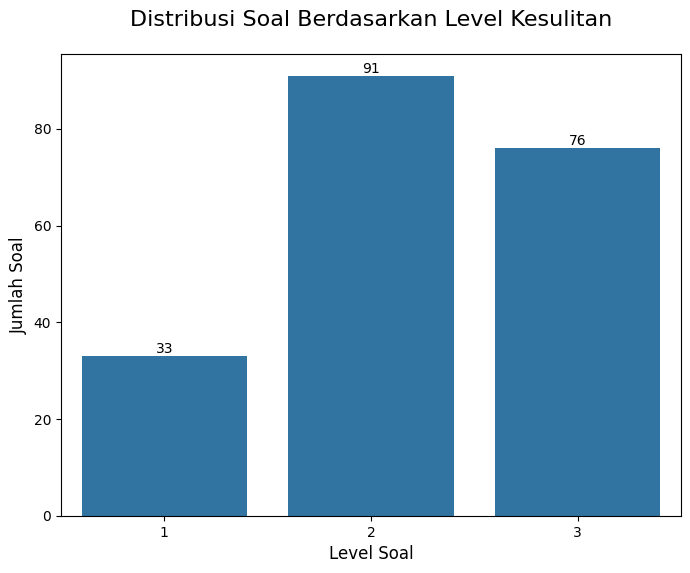

In [71]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=distribusi_level.index, y=distribusi_level.values, )

ax.set_title('Distribusi Soal Berdasarkan Level Kesulitan', fontsize=16, pad=20)
ax.set_xlabel('Level Soal', fontsize=12)
ax.set_ylabel('Jumlah Soal', fontsize=12)

for container in ax.containers:
    ax.bar_label(container)
plt.show()

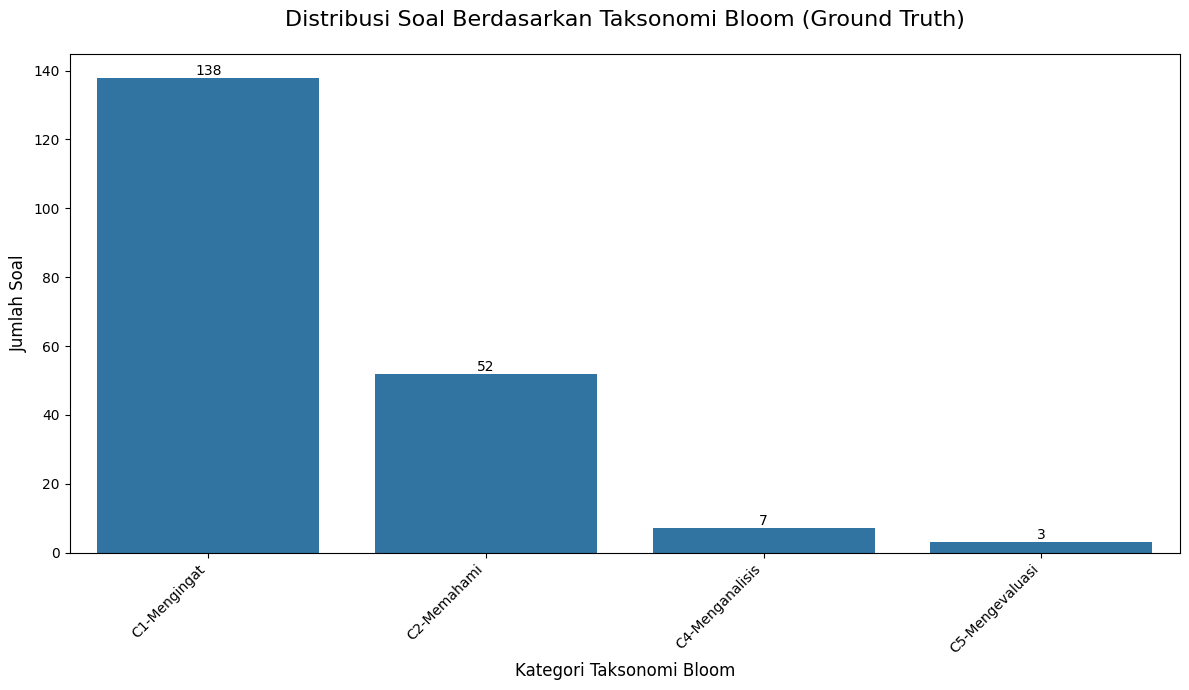

In [73]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=distribusi_bloom.index, y=distribusi_bloom.values, )

ax.set_title('Distribusi Soal Berdasarkan Taksonomi Bloom (Ground Truth)', fontsize=16, pad=20)
ax.set_xlabel('Kategori Taksonomi Bloom', fontsize=12)
ax.set_ylabel('Jumlah Soal', fontsize=12)

plt.xticks(rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout() 
plt.show()

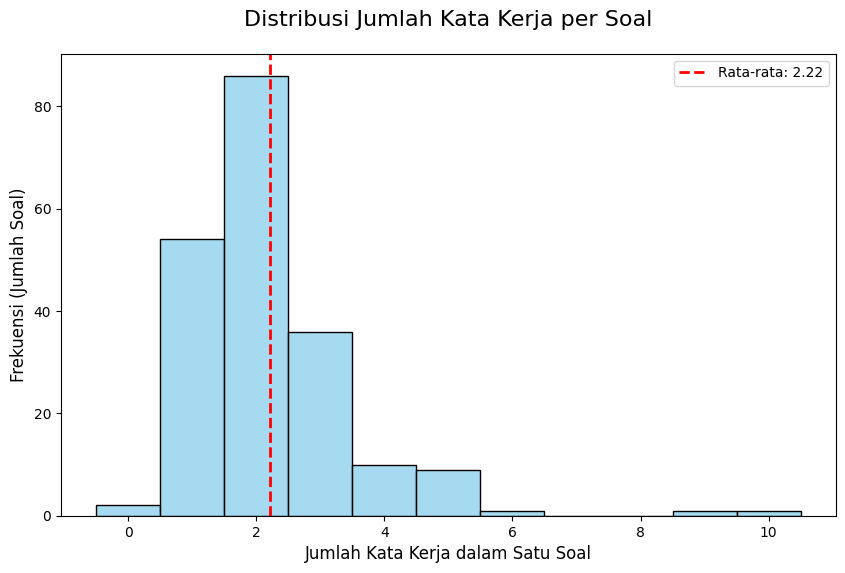

In [74]:
jumlah_kata_kerja_per_soal = df_full_notation['list_verb_stemmed'].apply(len)
rata_rata_kata_kerja = jumlah_kata_kerja_per_soal.mean()

plt.figure(figsize=(10, 6))
ax = sns.histplot(jumlah_kata_kerja_per_soal, discrete=True, kde=False, color='skyblue')

plt.axvline(
    x=rata_rata_kata_kerja,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Rata-rata: {rata_rata_kata_kerja:.2f}'
)

ax.set_title('Distribusi Jumlah Kata Kerja per Soal', fontsize=16, pad=20)
ax.set_xlabel('Jumlah Kata Kerja dalam Satu Soal', fontsize=12)
ax.set_ylabel('Frekuensi (Jumlah Soal)', fontsize=12)
ax.legend()

plt.show()